In [10]:
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
from os import listdir
import gc
import os

tf.logging.set_verbosity(tf.logging.INFO)

In [11]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # input layer should be of shape [:, NXCHANNELS, NVCHANNELS, 1]
    # NVCHANNELS: number of velocity bins
    
    NVCHANNELS=128
    NXCHANNELS=128
    
    input_layer = tf.reshape(features["x"], [-1,NXCHANNELS, NVCHANNELS, 1])
    
    # Convolutional Layer #1
    # Computes 8 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 128, 128, 1]
    # Output Tensor Shape: [batch_size, 128, 128, 8]
    conv1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 8,
        kernel_size = (5,5),
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 8 filter and stride of 2
    # Input Tensor Shape: [batch_size, 128, 8]
    # Output Tensor Shape: [batch_size, 32, 32, 8]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(4,4), strides=4)

    # Convolutional Layer #2
    # Computes 16 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 32, 32, 8]
    # Output Tensor Shape: [batch_size, 32,32 , 16]
    conv2 = tf.layers.conv2d(
      inputs  = pool1,
      filters = 16 ,
      kernel_size = [5,5],
      padding     ="same",
      activation  =tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 32, 32, 16]
    # Output Tensor Shape: [batch_size, 8, 8 , 16]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(4,4), strides=4)
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 32, 32, 16]
    # Output Tensor Shape: [batch_size, 8x8x16]
    pool2_flat = tf.reshape(pool2, [-1,  8*8*16])
    

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 16*32]
    # Output Tensor Shape: [batch_size, 128]
    dense = tf.layers.dense(inputs=pool2_flat, units=64, activation=tf.nn.relu)
    
    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    # Logits Layer
    
    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 1]
    beta_pred = tf.layers.dense(inputs=dropout, units=1)
    
    # Normalize the final layer to the range of beta
    # A simple Ax + b layer
    predictions = { "beta_pred": beta_pred }
        
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate Loss (for both TRAIN and EVAL modes)   
    # Simple Mean Squared 
    loss = tf.losses.mean_squared_error( labels, predictions['beta_pred'])
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = { "accuracy": tf.metrics.accuracy(
                    labels=labels, predictions=predictions["beta_pred"]) }
    return tf.estimator.EstimatorSpec( mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [20]:
def get_batch(N = 4, dims = (128,128)):
    """
    Create the PV slice from the PPV cube
    """
    datadir = "D:/ppvdata/"
    allfilename = listdir( datadir + 'vdata') 
    allspecindx = [ float(i.strip('_ppv.npy')) for i in allfilename ]
    
    ndata = len(allfilename)
    
    shuffleidx = np.random.permutation(ndata*N)
    
    X = []
    Y = []
    for idx in shuffleidx[:N]:
        filename = allfilename[idx % ndata ]
        ppvdata = np.load( datadir + 'vdata/' + '{}'.format(filename))
        specidx = allspecindx[idx % ndata ]
        
        x_not_y = round(np.random.random(1)[0])
        begin_idx = np.random.randint(0, 512 - 128)
        end_idx   = 128 + begin_idx
        slice_idx = np.random.randint(0,512)
        if x_not_y:
            pvslice = ppvdata[ slice_idx, begin_idx:end_idx ,:]
        else:
            pvslice = ppvdata[ begin_idx:end_idx, slice_idx,: ]
        
        X.append(pvslice)
        Y.append(specidx)
        del ppvdata
        del pvslice
        gc.collect()
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

In [21]:
def train_2d_cnn():
    # handcrafted training sample
    X,y = get_batch(N=100)
    
    # Create the Estimator
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
    sess_config = tf.ConfigProto(gpu_options=gpu_options)
    run_config = tf.estimator.RunConfig(session_config = sess_config)  
    beta_estimator = tf.estimator.Estimator(
          model_fn=cnn_model_fn, model_dir="./turbulence_2dconvnet_model", config=run_config)

    # Set up logging for predictions
    # Log the values in the "Softmax" tensor with label "probabilities"
    #     tensors_to_log = {"beta": "softmax_tensor"}
    #     logging_hook = tf.train.LoggingTensorHook(
    #       tensors=tensors_to_log, every_n_iter=50)



    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X},
        y=y[:,None],
        batch_size=32,
        num_epochs=None,
        shuffle=True)


    beta_estimator.train(
        input_fn=train_input_fn,
        steps=1000)

    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X},
        y=y[:,None],
        num_epochs=1,
        shuffle=False)


    eval_results = beta_estimator.evaluate(input_fn=eval_input_fn)


    beta_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X},
        y=y[:,None],
        num_epochs=1,
        shuffle=False)

    beta_predict = beta_estimator.predict(input_fn=beta_input_fn)
    print(eval_results)
    
    return beta_estimator

In [ ]:
for i in range(100):
    train_2d_cnn() 

INFO:tensorflow:Using config: {'_device_fn': None, '_keep_checkpoint_max': 5, '_is_chief': True, '_num_ps_replicas': 0, '_service': None, '_protocol': None, '_num_worker_replicas': 1, '_model_dir': './turbulence_2dconvnet_model', '_eval_distribute': None, '_experimental_distribute': None, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_train_distribute': None, '_global_id_in_cluster': 0, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001AE6A869978>, '_evaluation_master': '', '_log_step_count_steps': 100, '_task_type': 'worker', '_task_id': 0, '_save_checkpoints_steps': None}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorf

In [6]:
X,y = get_batch(N=100)

# Create the Estimator
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
run_config = tf.estimator.RunConfig(session_config = sess_config)  
beta_estimator = tf.estimator.Estimator(
      model_fn=cnn_model_fn, model_dir="./turbulence_2dconvnet_model", config=run_config)


beta_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X},
    y=y[:,None],
    num_epochs=1,
    shuffle=False)

beta_predict = beta_estimator.predict(input_fn=beta_input_fn)

INFO:tensorflow:Using config: {'_protocol': None, '_save_summary_steps': 100, '_num_worker_replicas': 1, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
}
, '_task_id': 0, '_experimental_distribute': None, '_tf_random_seed': None, '_log_step_count_steps': 100, '_global_id_in_cluster': 0, '_save_checkpoints_steps': None, '_service': None, '_device_fn': None, '_num_ps_replicas': 0, '_save_checkpoints_secs': 600, '_is_chief': True, '_eval_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018D9CDE8A20>, '_model_dir': './turbulence_2dconvnet_model', '_keep_checkpoint_max': 5, '_train_distribute': None, '_evaluation_master': ''}


In [7]:
tf_predicted_data = []
for bbb in beta_predict:
    tf_predicted_data.append(bbb['beta_pred'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./turbulence_2dconvnet_model\model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [8]:
import numpy
numpy.array(tf_predicted_data).shape

(100, 1)

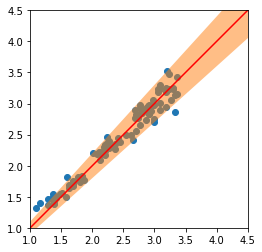

In [10]:
import matplotlib.pyplot as plt

plt.scatter( y,  tf_predicted_data )
plt.plot( range(1,6), range(1,6), color='r' )

beta_range = numpy.arange(1,6)
plt.fill_between( beta_range , 0.9*beta_range , 1.1*beta_range, alpha = 0.5  )
plt.xlim(1,4.5)
plt.ylim(1,4.5)
plt.axes().set_aspect('equal')


In [12]:
np.load('D:ppvdata/vdata/1.10_ppv.npy')

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [13]:
os.path.join('D:ppvdata/vdata','1.10_ppv.npy')


'D:ppvdata/vdata\\1.10_ppv.npy'